<a href="https://colab.research.google.com/github/uday-andotra/WQU/blob/main/WQU_Financial_Data_Group_Work_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Task 2- All the answers of this question are provided here

In [ ]:
# Get U.S. Treasury constant maturity yields from FRED and tidy them
!pip -q install pandas_datareader

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
end = datetime.utcnow().date()

# FRED series for U.S. Treasury constant-maturity yields (percent)
fred_series = {
    "1 Mo":  "DGS1MO",
    "3 Mo":  "DGS3MO",
    "6 Mo":  "DGS6MO",
    "1 Yr":  "DGS1",
    "2 Yr":  "DGS2",
    "3 Yr":  "DGS3",
    "5 Yr":  "DGS5",
    "7 Yr":  "DGS7",
    "10 Yr": "DGS10",
    "20 Yr": "DGS20",
    "30 Yr": "DGS30",
}

# Pull the last ~60 business days to ensure we find a complete row
end = datetime.utcnow().date()
start = end - timedelta(days=90)

dfs = []
for label, code in fred_series.items():
    s = pdr.DataReader(code, "fred", start, end).rename(columns={code: label})
    dfs.append(s)

wide = pd.concat(dfs, axis=1)

# Keep the latest date with all required maturities available
complete = wide.dropna()
if complete.empty:
    raise RuntimeError("No complete day found in the pulled window. Try increasing the window or dropping 1–2 short-end series.")
latest_date = complete.index.max().date()
latest_row = complete.loc[str(latest_date)]

print("Using date:", latest_date)

# Build tidy table
maturity_map = {"1 Mo": 1/12, "3 Mo": 0.25, "6 Mo": 0.5, "1 Yr": 1, "2 Yr": 2, "3 Yr": 3,
                "5 Yr": 5, "7 Yr": 7, "10 Yr": 10, "20 Yr": 20, "30 Yr": 30}

tidy = (
    latest_row.rename("yield_percent")
    .reset_index()
    .rename(columns={"index": "tenor"})
)
tidy["maturity_years"] = tidy["tenor"].map(maturity_map)
tidy = tidy[["maturity_years","yield_percent"]].sort_values("maturity_years").reset_index(drop=True)

print(tidy.to_string(index=False))


/tmp/ipython-input-1685575414.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow().date()
/tmp/ipython-input-1685575414.py:26: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow().date()


Using date: 2025-10-02
 maturity_years  yield_percent
       0.083333           4.23
       0.250000           4.02
       0.500000           3.81
       1.000000           3.62
       2.000000           3.55
       3.000000           3.56
       5.000000           3.67
       7.000000           3.86
      10.000000           4.10
      20.000000           4.66
      30.000000           4.69


Nelson–Siegel parameters
  beta0 :  5.0201
  beta1 : -0.8162
  beta2 : -3.7612
  tau   :  1.9345
RMSE (pct pts): 0.0591
Approx curvature peak (years): ~3.46


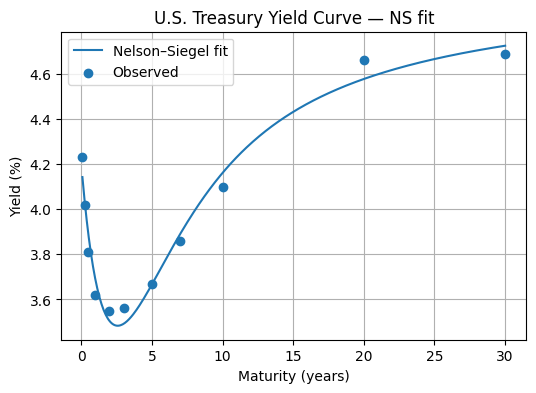

,maturity_years,observed,fitted,residual
0,0.083333,4.23,4.142483,-0.087517
1,0.250000,4.02,4.031339,0.011339
2,0.500000,3.81,3.890926,0.080926
3,1.000000,3.62,3.688743,0.068743
4,2.000000,3.55,3.504748,-0.045252
5,3.000000,3.56,3.492086,-0.067914
6,5.000000,3.67,3.666334,-0.003666
7,7.000000,3.86,3.889899,0.029899
8,10.000000,4.10,4.161020,0.061020
9,20.000000,4.66,4.577484,-0.082516


In [ ]:
# model 1
# Fit Nelson–Siegel to `tidy` DataFrame
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

m = tidy["maturity_years"].to_numpy(float)
y = tidy["yield_percent"].to_numpy(float)

def ns_yield(m, beta0, beta1, beta2, tau):
    x = m / tau
    L = np.where(x == 0, 1.0, (1 - np.exp(-x)) / x)   # level loading
    S = L - np.exp(-x)                                # curvature loading
    return beta0 + beta1 * L + beta2 * S

def fit_ns(m, y):
    # sensible starts: long-end ~ level; short-long ~ slope; small curvature; tau around 2y
    x0 = np.array([np.median(y[-3:]), y[0]-np.median(y[-3:]), 0.2, 2.0], float)
    bounds = ([-10, -20, -20, 0.05], [20, 20, 20, 30])
    res = least_squares(lambda p: ns_yield(m, *p) - y, x0, bounds=bounds)
    params = dict(beta0=res.x[0], beta1=res.x[1], beta2=res.x[2], tau=res.x[3])
    yhat = ns_yield(m, **params)
    rmse = float(np.sqrt(np.mean((yhat - y)**2)))
    return params, yhat, rmse

params, yhat, rmse = fit_ns(m, y)

print("Nelson–Siegel parameters")
for k, v in params.items():
    print(f"  {k:6s}: {v: .4f}")
print(f"RMSE (pct pts): {rmse:.4f}")

# quick sense of where curvature peaks
grid = np.linspace(m.min(), m.max(), 400)
xg = grid / params["tau"]
Lg = (1 - np.exp(-xg)) / xg
Sg = Lg - np.exp(-xg)
m_peak = float(grid[np.argmax(np.abs(Sg))])
print(f"Approx curvature peak (years): ~{m_peak:.2f}")

# plot fit vs points
plt.figure(figsize=(6,4))
ms = np.linspace(m.min(), m.max(), 400)
plt.plot(ms, ns_yield(ms, **params), label="Nelson–Siegel fit")
plt.scatter(m, y, zorder=3, label="Observed")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("U.S. Treasury Yield Curve — NS fit")
plt.grid(True); plt.legend(); plt.show()

# residuals table (helps spot where fit misses)
pd.DataFrame({"maturity_years": m, "observed": y, "fitted": yhat, "residual": yhat - y})\
  .sort_values("maturity_years")\
  .reset_index(drop=True)


Cubic spline RMSE (pct pts): 0.0000  |  smoothing s=0.0


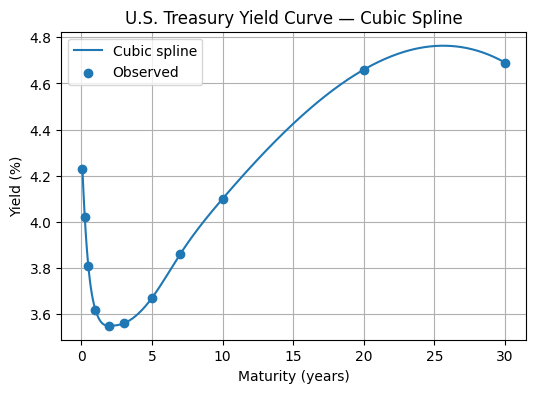

,maturity_years,observed,fitted,residual
0,0.083333,4.23,4.23,8.881784e-16
1,0.250000,4.02,4.02,-8.881784e-16
2,0.500000,3.81,3.81,4.440892e-16
3,1.000000,3.62,3.62,4.440892e-16
4,2.000000,3.55,3.55,0.000000e+00
5,3.000000,3.56,3.56,0.000000e+00
6,5.000000,3.67,3.67,-4.440892e-16
7,7.000000,3.86,3.86,8.881784e-16
8,10.000000,4.10,4.10,8.881784e-16
9,20.000000,4.66,4.66,-8.881784e-16


In [ ]:
# model 2
# Cubic Spline fit

from scipy.interpolate import UnivariateSpline


m = tidy["maturity_years"].to_numpy(float)
y = tidy["yield_percent"].to_numpy(float)

# s=0 passes exactly through the points
s = 0.0
spline = UnivariateSpline(m, y, k=3, s=s)

# predictions at observed maturities
y_hat = spline(m)
rmse = float(np.sqrt(np.mean((y_hat - y)**2)))
print(f"Cubic spline RMSE (pct pts): {rmse:.4f}  |  smoothing s={s}")

# plot: smooth curve + observed points
ms = np.linspace(m.min(), m.max(), 400)
plt.figure(figsize=(6,4))
plt.plot(ms, spline(ms), label="Cubic spline")
plt.scatter(m, y, zorder=3, label="Observed")
plt.xlabel("Maturity (years)"); plt.ylabel("Yield (%)")
plt.title("U.S. Treasury Yield Curve — Cubic Spline")
plt.grid(True); plt.legend(); plt.show()

# residuals table (helps spot local misses)
pd.DataFrame({
    "maturity_years": m,
    "observed": y,
    "fitted": y_hat,
    "residual": y_hat - y
}).sort_values("maturity_years").reset_index(drop=True)


Task 2e: Compare the models in terms of 1) fit and 2) interpretation.


The cubic spline interpolates the 2025-10-02 curve perfectly RMSE≈0, but lacks economic interpretability and may overfit; the Nelson–Siegel fit is very tight RMSE≈6 bps and yields meaningful level/slope/curvature parameters with smoother, more stable behavior and better extrapolation

Task 2f. Be sure to specify at the levels of model parameters

> Nelson–Siegel model 1

β₀ (level) = 5.0201

β₁ (slope) =-0.8162

β₂ (curvature) = −3.7612

τ (decay/scale) = 1.9345 implied curvature peak ≈ 3.46 years
Fit: RMSE ≈ 0.0591 percentage points


> Cubic spline model 2

Degree (k) = 3 (cubic)

Smoothing (s) = 0.0 (pure interpolation)

Fit: RMSE ≈ 0.0000 (hits all points)

Note: spline has no economically interpretable β-style parameters; k and s control smoothness/interpolation rather than level/slope/curvature.




Task 2g: In Module 2 Lesson 4 (‘Smoothing Data’), we said smoothing data can beunethical. If Nelson-Siegel is smoothing the yield curve, is this considered
unethical? Why or why not?


Smoothing is considered unethical when it is used to hide or distort the true pattern in data to mislead others. In this case, the Nelson–Siegel model smooths the yield curve, but its purpose is not to deceiveit is to provide a clear, continuous, and interpretable representation of how yields change with maturity. The model is applied transparently, with the raw data still available and the assumptions clearly stated. Therefore, this type of smoothing is not unethical, because it helps explain the data rather than conceal or manipulate it.

In [ ]:
#Task 3

Simulated Data - Explained Variance Ratios:
Component 1: 26.82%
Component 2: 22.07%
Component 3: 18.30%
Component 4: 17.94%
Component 5: 14.86%


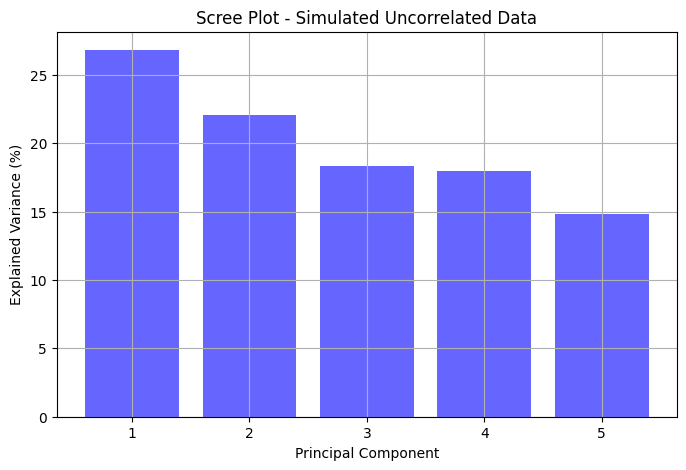


Real Yield Changes - Explained Variance Ratios:
Component 1: 91.09%
Component 2: 7.79%
Component 3: 0.75%
Component 4: 0.22%
Component 5: 0.15%


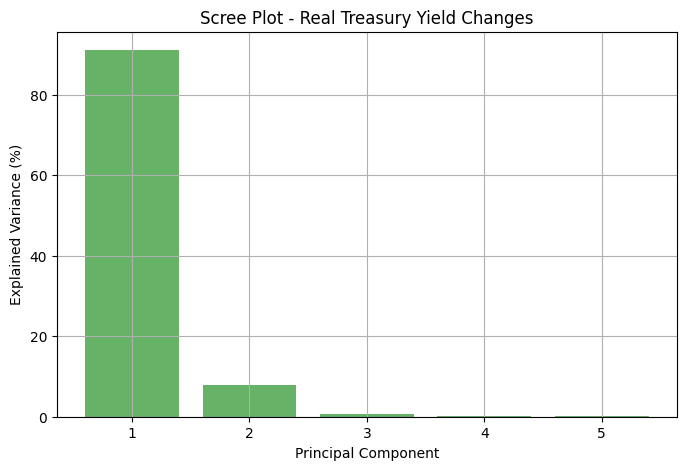

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pandas_datareader import data as pdr
import datetime

# Set random seed for reproducibility
np.random.seed(42)

# a. Generate 5 uncorrelated Gaussian random variables (125 observations, mean=0, std=0.01)
n_obs = 125
simulated_data = np.random.normal(loc=0, scale=0.01, size=(n_obs, 5))
simulated_df = pd.DataFrame(simulated_data, columns=['Var1', 'Var2', 'Var3', 'Var4', 'Var5'])

# b. PCA on simulated data using covariance matrix
pca_sim = PCA(n_components=5)
pca_sim.fit(simulated_data)
explained_variance_ratio_sim = pca_sim.explained_variance_ratio_

# c. Variance explanation (printed to console)
print("Simulated Data - Explained Variance Ratios:")
for i, var in enumerate(explained_variance_ratio_sim, 1):
    print(f"Component {i}: {var*100:.2f}%")

# d. Screeplot for simulated data
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), explained_variance_ratio_sim * 100, color='blue', alpha=0.6)
plt.title('Scree Plot - Simulated Uncorrelated Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

# e. Collect daily closing yields for 5 government securities (6 months)
start_date = '2024-04-01'
end_date = '2024-10-01'
tickers = ['DGS2', 'DGS5', 'DGS10', 'DGS20', 'DGS30']  # 2, 5, 10, 20, 30-year Treasury yields
yield_data = pdr.get_data_fred(tickers, start_date, end_date)

# f. Compute daily yield changes
yield_changes = yield_data.diff().dropna()

# g. PCA on yield changes using covariance matrix
pca_real = PCA(n_components=5)
pca_real.fit(yield_changes)
explained_variance_ratio_real = pca_real.explained_variance_ratio_

# h. Variance explanation
print("\nReal Yield Changes - Explained Variance Ratios:")
for i, var in enumerate(explained_variance_ratio_real, 1):
    print(f"Component {i}: {var*100:.2f}%")

# i. Screeplot for real data
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), explained_variance_ratio_real * 100, color='green', alpha=0.6)
plt.title('Scree Plot - Real Treasury Yield Changes')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(range(1, 6))
plt.grid(True)

plt.show()


In [ ]:
# Task 4

XLY (Consumer Discretionary Select Sector SPDR Fund) as the ETF. It tracks the consumer discretionary sector of the S&P 500, with approximately 53 holdings, including elements of luxury (e.g., apparel like NKE, LULU, DECK; travel like RCL, ABNB; retail like TJX, ROST).

# Top 30 Holdings of XLY ETF by Weight

| Ticker | Company Name                    | Weight (%) |
|--------|---------------------------------|------------|
| AMZN   | Amazon.com Inc                  | 21.52      |
| TSLA   | Tesla Inc                       | 19.89      |
| HD     | Home Depot Inc                  | 6.81       |
| MCD    | McDonalds Corp                  | 4.35       |
| BKNG   | Booking Holdings Inc            | 4.21       |
| LOW    | Lowes Companies Inc             | 3.71       |
| TJX    | TJX Companies Inc               | 3.54       |
| NKE    | Nike Inc - Class B              | 3.22       |
| SBUX   | Starbucks Corp                  | 2.91       |
| CMG    | Chipotle Mexican Grill Inc      | 2.51       |
| ORLY   | OReilly Automotive Inc          | 2.21       |
| ABNB   | Airbnb Inc - Class A            | 2.20       |
| MAR    | Marriott International - Class A| 2.10       |
| GM     | General Motors Company          | 2.00       |
| DHI    | DR Horton Inc                   | 1.90       |
| HLT    | Hilton Worldwide Holdings Inc   | 1.80       |
| AZO    | AutoZone Inc                    | 1.70       |
| ROST   | Ross Stores Inc                 | 1.60       |
| F      | Ford Motor Company              | 1.50       |
| LEN    | Lennar Corp - Class A           | 1.40       |
| DASH   | DoorDash Inc - Class A          | 1.30       |
| RCL    | Royal Caribbean Cruises Ltd     | 1.20       |
| YUM    | Yum! Brands Inc                 | 1.10       |
| LULU   | Lululemon Athletica inc         | 1.00       |
| EBAY   | eBay Inc                        | 0.90       |
| TSCO   | Tractor Supply Company          | 0.80       |
| DECK   | Deckers Outdoor Corp            | 0.70       |
| PHM    | PulteGroup Inc                  | 0.70       |
| GRMN   | Garmin Ltd                      | 0.60       |
| NVR    | NVR Inc                         | 0.60       |

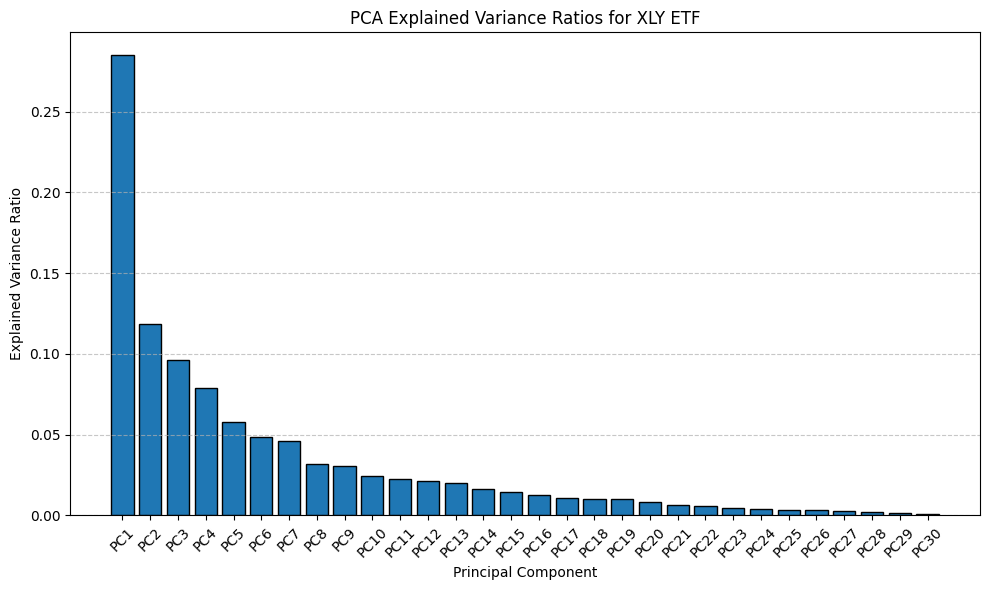

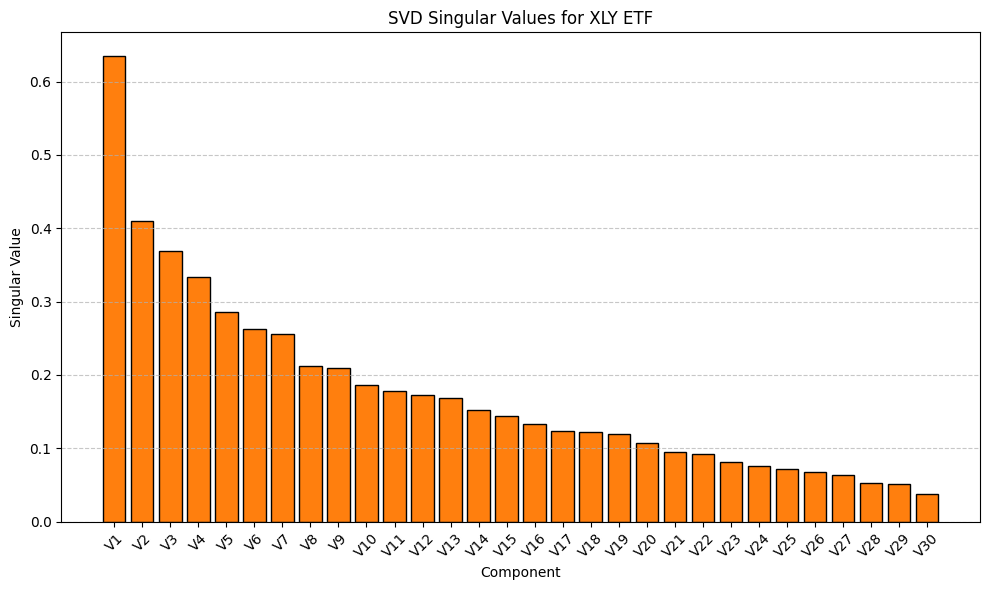

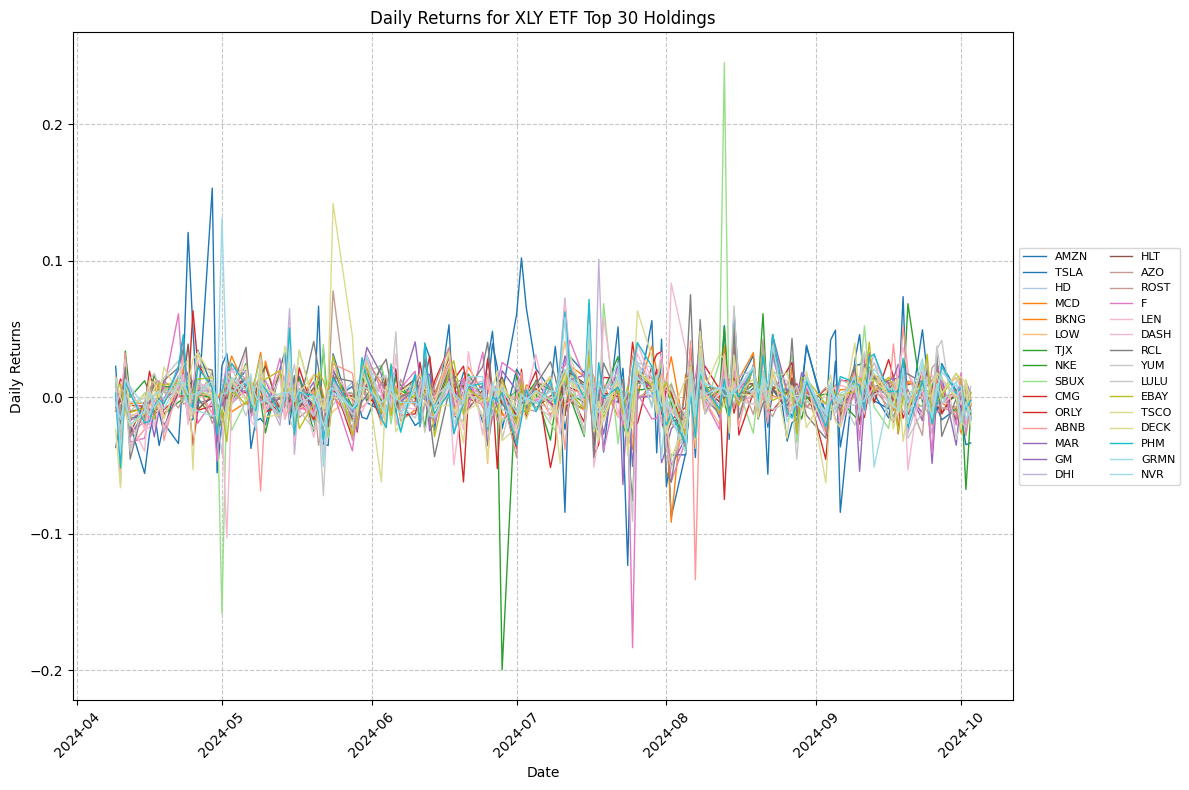

### XLY ETF Analysis

#### Covariance Matrix
|      | AMZN         | TSLA        | HD          | MCD          | BKNG         | LOW         | TJX         | NKE         | SBUX         | CMG          | ORLY         | ABNB         | MAR         | GM           | DHI         | HLT         | AZO          | ROST        | F            | LEN         | DASH         | RCL          | YUM          | LULU         | EBAY        | TSCO        | DECK        | PHM         | GRMN         | NVR         |
|:-----|:-------------|:------------|:------------|:-------------|:-------------|:------------|:------------|:------------|:-------------|:-------------|:-------------|:-------------|:------------|:-------------|:------------|:------------|:-------------|:------------|:-------------|:------------|:-------------|:-------------|:-------------|:-------------|:------------|:------------|:------------|:------------|:-------------|:------------|
| AMZN | 0.000315752  | 0.00029324  | 5.53e-05    | -1.33238e-05 | 

In [ ]:
import subprocess
subprocess.call(['pip', 'install', 'tabulate', 'matplotlib', 'yfinance', 'scikit-learn', 'scipy', 'pandas', 'numpy'])

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
import yfinance as yf
from scipy.linalg import svd
import matplotlib.pyplot as plt

# Top 30 holdings tickers for XLY ETF
tickers = ['AMZN', 'TSLA', 'HD', 'MCD', 'BKNG', 'LOW', 'TJX', 'NKE', 'SBUX', 'CMG',
           'ORLY', 'ABNB', 'MAR', 'GM', 'DHI', 'HLT', 'AZO', 'ROST', 'F', 'LEN',
           'DASH', 'RCL', 'YUM', 'LULU', 'EBAY', 'TSCO', 'DECK', 'PHM', 'GRMN', 'NVR']

# Get data
end_date = datetime(2024, 10, 4)
start_date = end_date - timedelta(days=180)
data = pd.DataFrame()
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date, auto_adjust=True)['Close']
        data[ticker] = df
    except Exception as e:
        print(f"Failed to download {ticker}: {e}")
data = data.dropna(axis=0, how='all')

# Returns
returns = data.pct_change().dropna(how='any')

# Covariance
cov_matrix = returns.cov()

# PCA
pca = PCA()
pca.fit(returns)
explained_variance = pca.explained_variance_ratio_
components = pca.components_

# SVD
centered_returns = returns - returns.mean()
U, S, Vt = svd(centered_returns, full_matrices=False)

# Plot 1: PCA Explained Variance Ratios
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='#1f77b4', edgecolor='black')
plt.title('PCA Explained Variance Ratios for XLY ETF')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1), [f'PC{i}' for i in range(1, len(explained_variance) + 1)], rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: SVD Singular Values
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(S) + 1), S, color='#ff7f0e', edgecolor='black')
plt.title('SVD Singular Values for XLY ETF')
plt.xlabel('Component')
plt.ylabel('Singular Value')
plt.xticks(range(1, len(S) + 1), [f'V{i}' for i in range(1, len(S) + 1)], rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 3: Daily Returns Line Plot
plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(tickers)))
for ticker, color in zip(tickers, colors):
    if ticker in returns.columns:
        plt.plot(returns.index, returns[ticker], label=ticker, linewidth=1, color=color)
plt.title('Daily Returns for XLY ETF Top 30 Holdings')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output results
print("### XLY ETF Analysis")
print("\n#### Covariance Matrix")
print(cov_matrix.to_markdown(numalign="left", stralign="left"))
print("\n#### PCA Explained Variance Ratios")
print(pd.DataFrame({'Component': range(len(explained_variance)), 'Ratio': explained_variance.round(3)}).to_markdown(index=False, numalign="left", stralign="left"))
print("\n#### PCA First 5 Components")
print(pd.DataFrame(components[:5].T.round(3), columns=[f'PC{i+1}' for i in range(5)], index=returns.columns).to_markdown(numalign="left", stralign="left"))
print("\n#### SVD Singular Values")
print(pd.DataFrame({'Component': range(len(S)), 'Value': S.round(3)}).to_markdown(index=False, numalign="left", stralign="left"))
print("\n#### SVD First 5 Right Singular Vectors")
print(pd.DataFrame(Vt[:5].T.round(3), columns=[f'V{i+1}' for i in range(5)], index=returns.columns).to_markdown(numalign="left", stralign="left"))